# 2D variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
import itertools
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Get the TFs

In [4]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts_deep.h5ad')

In [6]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [7]:
adata.shape

(69958, 36588)

### Setup memento

In [8]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [9]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [10]:
memento.setup_memento(adata, q_column='q')

### Compute correlations for STAT1

In [11]:
tf = 'STAT1'
ct = ['ciliated']
stim = 'beta'

def get_2d_moments(tf, ct, stim):
    
    adata_stim = adata.copy()[
        adata.obs.cell_type.isin(ct) & \
        adata.obs.stim.isin(['control', stim])].copy()
    # time_converter={0:0, int(tp):1}
    # adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

    memento.create_groups(adata_stim, label_columns=['time', 'donor'])
    memento.compute_1d_moments(adata_stim, min_perc_group=.9)
    moment_1d_df = memento.get_1d_moments(adata_stim, groupby='time')

    memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

    moment_df = memento.get_2d_moments(adata_stim, groupby='time')
    
    return moment_df


In [12]:
beta_df = get_2d_moments('STAT1', ['ciliated'], 'beta')
alpha_df = get_2d_moments('STAT1', ['ciliated'], 'alpha')
gamma_df = get_2d_moments('STAT1', ['ciliated'], 'gamma')
lambda_df = get_2d_moments('STAT1', ['ciliated'], 'lambda')

beta_df['stim'] = 'beta'
alpha_df['stim'] = 'alpha'
df = pd.concat([alpha_df, beta_df])

/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg/memento/estimator.py:100: RuntimeWarning: invalid value encountered in log
/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.5-py3.7.egg/memento/main.py:539: RuntimeWarning: invalid value encountered in true_divide
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


(-0.75, 1)

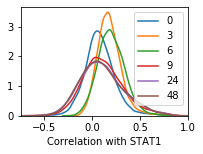

In [23]:
plt.figure(figsize=(3, 2))
for tp in ['0', '3', '6', '9', '24', '48']:#['0', '3', '6', '9', '24', '48']:
    sns.distplot(beta_df['time_' + tp], hist=False, label=tp)
# plt.legend(, frameon=False)
plt.xlabel('Correlation with STAT1')
plt.xlim(-0.75, 1)

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import pandas as pd
import numpy as np
from sklearn.neighbors import KernelDensity

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


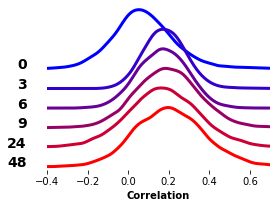

In [21]:
colors = ['#0000ff', '#3300cc', '#660099', '#990066', '#cc0033', '#ff0000']

gs = grid_spec.GridSpec(6,1)
fig = plt.figure(figsize=(4,3))

i = 0

ax_objs = []
for i, tp in enumerate(['0', '3', '6', '9', '24', '48']):
    x = lambda_df['time_' + tp].values
    x = x[np.isfinite(x)]
    x_d = np.linspace(-0.7,1, 1000)

    kde = KernelDensity(bandwidth=0.025, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),lw=3, color=colors[i])
#     ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color=colors[i])


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.4,0.7)
#     ax_objs[-1].set_ylim(0,2.5)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticklabels([])

    if i == 6-1:
        ax_objs[-1].set_xlabel("Correlation", fontsize=10,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])
        ax_objs[-1].set_xticks([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
#     
    ax_objs[-1].set_yticks([])
#     adj_country = country.replace(" ","\n")
    ax_objs[-1].text(-0.5,0,tp,fontweight="bold",fontsize=14,ha="right")


    i += 1

gs.update(hspace=-0.7)

# fig.text(0.07,0.85,"Distribution of Aptitude Test Results from 18 – 24 year-olds",fontsize=20)

plt.tight_layout()
plt.show()

### Look for STAT1 DC genes

In [14]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [15]:
import os

In [19]:
done_files = os.listdir('/data_volume/ifn_hbec/tf_test/')

In [88]:
tf = 'REL'

cts = [['ciliated']]
tps = ['3']
stims = ['beta']


for ct in cts:
    for tp in tps:
        for stim in stims:
            
            fname = '{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
            if fname in done_files:
                continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            moment_df.to_csv('/data_volume/ifn_hbec/coex_test/moments_{}_{}_{}_{}.csv'.format('-'.join(ct), stim, tp, tf), index=False)
            gene_list = adata_stim.var.index.tolist()#moment_df[(moment_df['time_step_0'] > 0.35) | (moment_df['time_step_1'] > 0.35)].gene_2.tolist()

            memento.compute_2d_moments(adata_stim, list(itertools.product([tf], gene_list)))

            memento.ht_2d_moments( 
                adata_stim, 
                formula_like='1 + time_step',
                cov_column='time_step', 
                num_boot=10000, 
                verbose=1,
                num_cpus=13)

            if 'mv_regressor' in adata_stim.uns['memento']:
                del adata_stim.uns['memento']['mv_regressor']
            adata_stim.write('/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))

starting ['ciliated'] 3 beta


[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    1.9s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:   10.1s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   25.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   45.9s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:  1.2min
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:  1.7min
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  2.3min
[Parallel(n_jobs=13)]: Done 3174 tasks      | elapsed:  3.1min
[Parallel(n_jobs=13)]: Done 4024 tasks      | elapsed:  3.9min
[Parallel(n_jobs=13)]: Done 4974 tasks      | elapsed:  4.8min
[Parallel(n_jobs=13)]: Done 6024 tasks      | elapsed:  5.8min
[Parallel(n_jobs=13)]: Done 7174 tasks      | elapsed:  6.9min
[Parallel(n_jobs=13)]: Done 8424 tasks      | elapsed:  8.1min
[Parallel(n_jobs=13)]: Done 9641 out of 9641 | elapsed:  9.3min finished
... storing 'memento_group' as cate

### What are the STAT1 DC genes?

In [89]:
stim = 'beta'
tp = '3'
ct = ['ciliated']

fname = '/data_volume/ifn_hbec/tf_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf)
adata_result = sc.read(fname)

In [90]:
moments = memento.get_2d_moments(adata_result, groupby='time')
res_df = memento.get_2d_ht_result(adata_result)
rel_res_df = memento.get_2d_ht_result(adata_stim)

(array([761.,   0.,   0.,   0.,   0., 199.,   0.,   0.,   0.,   0.,  34.,
          0.,   0.,   0.,   4.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
        2.6, 2.8, 3. ], dtype=float32),
 <a list of 15 Patch objects>)

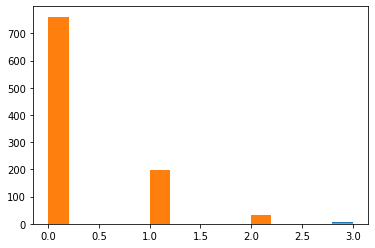

In [104]:
plt.hist(adata_stim[adata_stim.obs.time == '0', :][:, 'RELA'].X.todense().A1, bins=15)
plt.hist(adata_stim[adata_stim.obs.time == '3', :][:, 'RELA'].X.todense().A1, bins=15)


In [91]:
rel_res_df.query('gene_2.str.startswith("HLA")', engine='python')

,gene_1,gene_2,corr_coef,corr_se,corr_pval
3132,REL,HLA-F,0.213500,0.266036,0.430057
3133,REL,HLA-A,0.320647,0.170409,0.084492
3142,REL,HLA-E,0.305155,0.206408,0.157984
3155,REL,HLA-C,0.433682,0.172806,0.038196
3156,REL,HLA-B,0.539057,0.157651,0.004900
3191,REL,HLA-DRA,0.177265,0.164524,0.253075
3192,REL,HLA-DRB1,0.278370,0.167853,0.100090
3193,REL,HLA-DQB1,-0.210185,0.246321,0.379462
3199,REL,HLA-DMB,0.346485,0.281236,0.219678
3200,REL,HLA-DMA,0.251941,0.212429,0.225377


In [79]:
moments.query('gene_2.str.startswith("HLA-")', engine='python')

,gene_1,gene_2,time_3,time_0
324,STAT1,HLA-F,0.516336,0.303196
325,STAT1,HLA-A,0.435438,0.184255
326,STAT1,HLA-E,0.626379,0.415575
327,STAT1,HLA-C,0.530611,0.319793
328,STAT1,HLA-B,0.437998,0.201227


In [80]:
wired_pairs = moments.query('time_0 > 0.25 | time_{} > 0.25'.format(tp))

In [81]:
filtered_res_df = df.merge(wired_pairs, on=['gene_1', 'gene_2'])
filtered_res_df['corr_fdr'] = memento.util._fdrcorrect(filtered_res_df['corr_pval'])

In [82]:
filtered_res_df.query('corr_fdr < 0.1 & corr_coef > 0')


,gene_1,gene_2,corr_coef,corr_se,corr_pval,time_3,time_0,corr_fdr
21,STAT1,KHDRBS1,0.785668,0.143838,0.000111,0.336625,-0.100998,0.045364
40,STAT1,DHCR24,0.437424,0.129056,0.001300,0.293888,0.131979,0.045364
46,STAT1,GBP3,0.445695,0.137708,0.001800,0.476064,0.181447,0.046070
56,STAT1,CSDE1,0.442232,0.155749,0.006199,0.513827,0.160636,0.096644
80,STAT1,PRRC2C,0.538987,0.154386,0.001200,0.420931,0.114498,0.045364
108,STAT1,PDIA6,0.511589,0.131297,0.001345,0.322810,0.060145,0.045364
111,STAT1,LAPTM4A,0.527373,0.113401,0.000219,0.307413,0.061655,0.045364
119,STAT1,CEBPZ,0.511687,0.172038,0.003500,0.347672,0.068690,0.067893
128,STAT1,TMSB10,0.279128,0.075335,0.001553,0.379154,0.200797,0.045364
142,STAT1,PPIG,0.511887,0.155762,0.003400,0.284333,0.065166,0.067893


In [64]:
for g in filtered_res_df.query('corr_fdr < 0.1 & corr_coef > 0').gene_2.tolist():
    print(g)

DHCR24
GBP3
PRRC2C
LAPTM4A
TMSB10
PPIG
NCL
EIF4A2
HNRNPD
LARP7
HLA-A
HLA-C
HLA-B
CLIC1
CD164
LY6E
DNAJA1
HNRNPK
EIF4G2
PRRG4
TMEM123
UBC
SAP18
ITM2B
HNRNPC
CHURC1
B2M
COX5A
PSMA4
H3F3B
PLEKHJ1
RABAC1
ZNFX1


In [52]:
filtered_res_df.shape

(869, 7)

In [53]:
res_df.shape

(891, 5)

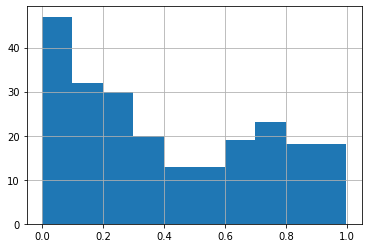

In [49]:
filtered_res_df.corr_pval.hist()